In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time

%matplotlib inline

In [2]:
vehicles_images = glob.glob('//Users/ahmad/Desktop/Training/vehicles/**/*.png')
nonvehicle_images = glob.glob('//Users/ahmad/Desktop/Training/non-vehicles/**/*.png')
print(len(vehicles_images), len(nonvehicle_images))

8792 8968


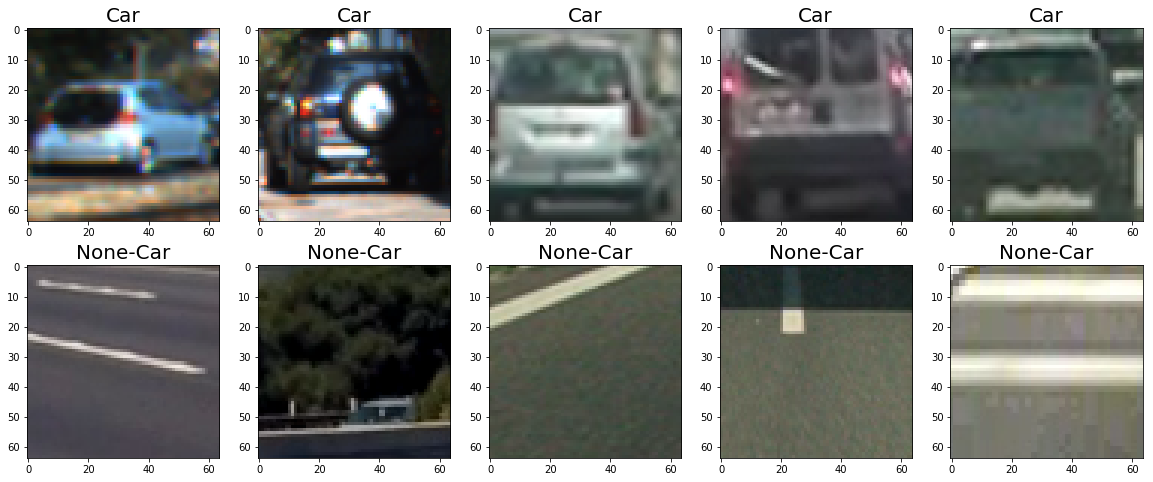

In [3]:
fig, axs = plt.subplots(2,5, figsize=(20, 8))
fig.subplots_adjust(hspace = .2, wspace=.2)

for i in range(5):
    ran_index = np.random.randint(0,len(vehicles_images))
    ran_img = cv2.imread(vehicles_images[ran_index])
    ran_img = cv2.cvtColor(ran_img, cv2.COLOR_BGR2RGB)
    axs[0, i].imshow(ran_img)
    axs[0, i].set_title('Car', fontsize=20)

for i in range(5):
    ran_index = np.random.randint(0,len(vehicles_images))
    ran_img = cv2.imread(nonvehicle_images[ran_index])
    ran_img = cv2.cvtColor(ran_img, cv2.COLOR_BGR2RGB)
    axs[1, i].imshow(ran_img)
    axs[1, i].set_title('None-Car', fontsize=20)


In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

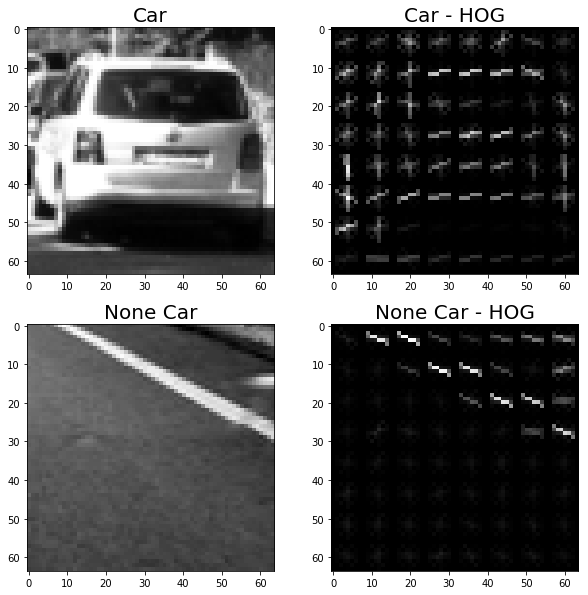

In [5]:
fig, axs = plt.subplots(2,2, figsize=(10, 10))
fig.subplots_adjust(hspace = .2, wspace=.2)

ran_index = np.random.randint(0,len(vehicles_images))
ran_img = cv2.imread(vehicles_images[ran_index])
ran_img = cv2.cvtColor(ran_img, cv2.COLOR_BGR2GRAY)
features, hog_image = get_hog_features(ran_img, orient = 11, 
                        pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)

axs[0,0].imshow(ran_img, cmap='gray')
axs[0,0].set_title('Car', fontsize=20)
axs[0,1].imshow(hog_image, cmap='gray')
axs[0,1].set_title('Car - HOG', fontsize=20)

ran_index = np.random.randint(0,len(vehicles_images))
ran_img = cv2.imread(nonvehicle_images[ran_index])
ran_img = cv2.cvtColor(ran_img, cv2.COLOR_BGR2GRAY)
features, hog_image = get_hog_features(ran_img, orient = 9, 
                        pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)

axs[1,0].imshow(ran_img, cmap='gray')
axs[1,0].set_title('None Car', fontsize=20)
axs[1,1].imshow(hog_image, cmap='gray')
axs[1,1].set_title('None Car - HOG', fontsize=20)

In [6]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

## Training a classifier

In [27]:
from sklearn.model_selection import GridSearchCV

#colorspace_list = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
colorspace_list = ['YCrCb']
orient = 11
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

for colorspace in colorspace_list:
    vehicles_features = extract_features(vehicles_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
    nonvehicle_features = extract_features(nonvehicle_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
    X = np.vstack((vehicles_features, nonvehicle_features)).astype(np.float64)  
    y = np.hstack((np.ones(len(vehicles_features)), np.zeros(len(nonvehicle_features))))
    
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    
    print("Started training for ", colorspace)
    parameters = {'C':[0.1]}
    svc = LinearSVC()
    clf = GridSearchCV(svc, parameters)
    clf.fit(X_train, y_train)
    #svc.fit(X_train, y_train)
    print("Best C is: ", clf.best_params_)
    print("Best test accuracy with ", colorspace, " color space is: ", round(clf.score(X_test, y_test), 4))

Started training for  YCrCb
Best C is:  {'C': 0.1}
Best test accuracy with  YCrCb  color space is:  0.9834


# Finding cars in a window

In [61]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, xstart, xstop, scale, cells_per_step, vis = False):
    
    svc = clf
    orient = 11
    pix_per_cell = 8
    cell_per_block = 2
    
    rectangles = []
    img = img.astype(np.float32)/255   
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    
    # Conversion to HSV colorspace
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window =  (window // pix_per_cell) - 1
    #cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            ########################
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1)) 
            ########################
            
            test_prediction = clf.predict(hog_features)
            
            if test_prediction == 1 or vis:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart))) 
                
    return rectangles

In [29]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

8


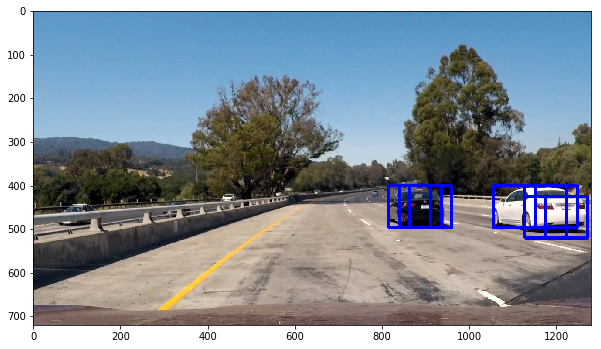

In [62]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
xstart = 0
xstop = 1350
scale = 1.5
cells_per_step = 2

rects = find_cars(test_img, ystart, ystop, xstart, xstop, scale, cells_per_step, vis=False)
print(len(rects))
plt.figure(figsize=(10,10))
plt.imshow(draw_boxes(test_img, rects))

## Experimenting with the window search areas

28
28


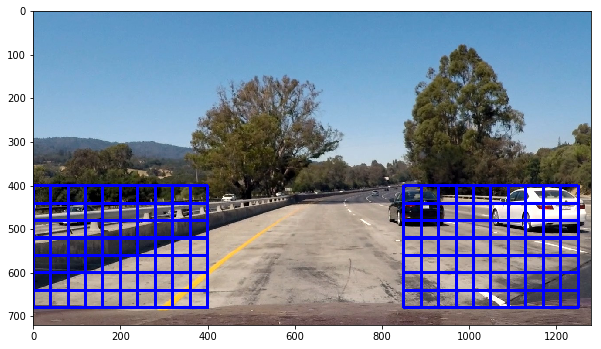

In [143]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects1 = find_cars(test_img, 400, 680, 850, 1280, 2.5, 2, vis=True)
print(len(rects1))

rects2 = find_cars(test_img, 400, 680, 0, 400, 2.5, 2, vis=True)
print(len(rects2))
plt.figure(figsize=(10,10))
img1 = draw_boxes(test_img, rects1) 
img2 = draw_boxes(img1, rects2)
plt.imshow(img2)

(720, 1280, 3)
85
85


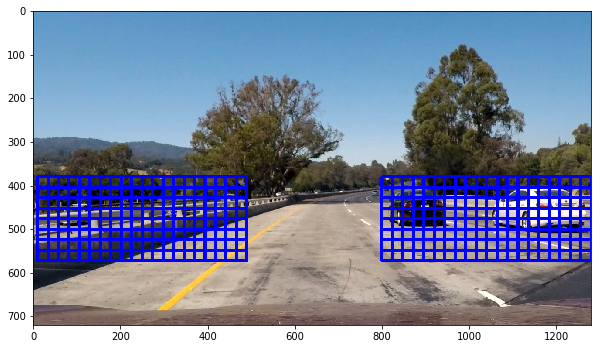

In [151]:
test_img = mpimg.imread('./test_images/test1.jpg')
print(test_img.shape)

rects1 = find_cars(test_img, 380, 580, 800, 1280, 1.5, 2, vis=True)
print(len(rects1))

rects2 = find_cars(test_img, 380, 580, 10, 490, 1.5, 2, vis=True)
print(len(rects2))
plt.figure(figsize=(10,10))
img1 = draw_boxes(test_img, rects1) 
img2 = draw_boxes(img1, rects2)
plt.imshow(img2)

(720, 1280, 3)
270


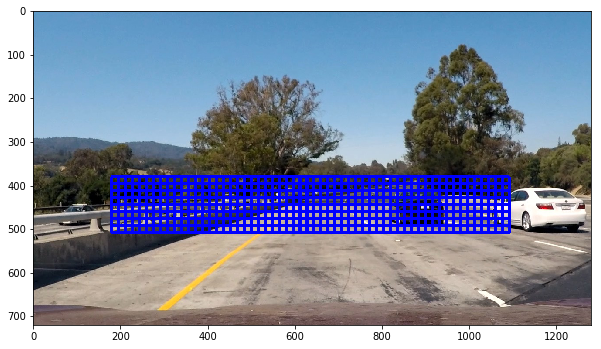

In [152]:
test_img = mpimg.imread('./test_images/test1.jpg')
print(test_img.shape)
ystart = 400
ystop = 520
xstart = 750
xstop = 1100
scale = 1
cells_per_step = 2

rects1 = find_cars(test_img, 380, 520, 180, 1100, scale, cells_per_step, vis=True)
print(len(rects1))

plt.figure(figsize=(10,10))
img1 = draw_boxes(test_img, rects1) 
plt.imshow(img1)

(720, 1280, 3)
37


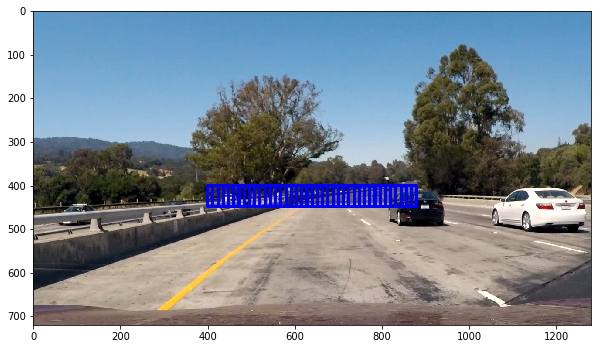

In [133]:
test_img = mpimg.imread('./test_images/test1.jpg')
print(test_img.shape)
ystart = 400
ystop = 450
xstart = 400
xstop = 880
scale = 0.75
cells_per_step = 2

rects1 = find_cars(test_img, ystart, ystop, xstart, xstop, scale, cells_per_step, vis=True)
print(len(rects1))

plt.figure(figsize=(10,10))
img1 = draw_boxes(test_img, rects1) 
plt.imshow(img1)